-------------------------------------------------------------------

- **Aluno:** Renato Andrade Mosqueira Furtado
- **Matrícula:** 102100652
- **e-mail:** renato.andrade@engenharia.ufjf.br
- **Disciplina:** Planejamento de Sistemas Elétricos
- **Objetivo:** formular genericamente um problema de otimização a fim de estimar as vazões para qualquer usina hidrelétrica.

-------------------------------------------------------------------

# **Instalação do PySDDP**

In [1]:
!pip install PySDDP

# **Importação do dados e bibliotecas**

- Leitura do deck de dados disponibilizados no site do CCEE na pasta alocada no drive do usuário. Deve-se, portanto, trocar a variável **CAMINHO** colocando o endereço de acesso à pasta.

In [2]:
from google.colab import drive
import os
from google.colab import files


drive.mount('/content/gdrive')

print(os.getcwd())


#============== Usuário deve trocar aqui de acordo com a pasta utilizada no drive ================
Caminho = 'gdrive/My Drive/Colab Notebooks/Planejamento Energético/Dados Newave/'
#=================================================================================================

Mounted at /content/gdrive
/content


In [3]:
from PySDDP.Pen import Newave
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from cvxopt import matrix,solvers

In [4]:
casoestudo = Newave(Caminho)

OK! Leitura do CASO.DAT realizada com sucesso.
OK! Leitura do ARQUIVOS.DAT realizada com sucesso.
OK! Leitura do DGER.DAT realizada com sucesso.
OK! Leitura do HIDR.DAT realizada com sucesso.
OK! Leitura do VAZOES.DAT realizada com sucesso.
OK! Leitura do MODIF.DAT realizada com sucesso. ( 99 Usinas Hidraulicas Modificadas )
OK! Leitura do EXPH.DAT realizada com sucesso. ( 2 Usinas Hidraulicas Expandidas )
OK! Leitura do CONFHD.DAT realizada com sucesso.
OK! Leitura do REE.DAT realizada com sucesso. ( 12 Reservatórios Equivalentes de Energia Foram Lidos )
OK! Leitura do SISTEMA.DAT realizada com sucesso.


# **Leitura da usina e dados da otimização**

- **Dados de entrada preenchidos pelo usuário:**
 - *Nome_usina*:deve-se colocar o nome da usina a qual o usuário deseja estudar;
 - *Ordem*: corresponde à quantidade de coeficientes que se deseja aplicar a fim de estimar as vazões (**ESSE NÚMERO DEVE VARIAR DE 1 até 12**);

 - *Mes_estimado*: variável do tipo *string* que indica o mês cujos coeficientes serão determinados para estimar as vazões;
 - *Ano_inicial*: variável que indica a partir de qual ano será feita o cálculo dos coeficientes. Em outras palavras, indica o ano a partir do qual as vazões em todos os meses são conhecidas;
 - *Ano_final*: variável que indica qual o último ano a ser utilizado para cálculo dos coeficientes, ou seja, o último ano no qual todas as vazões mensais são conhecidas.
  - *Progresso*: se **True** irá mostrar o progresso da otimização, se **False** não mostra.


- **OBS:**

  - a variável *Ordem* deve ser um valor entre 1 e 11;
  - a variável *Ano_inicial* deve ser maior ou igual a 1932;
  - a variável *Ano_final* deve ser menor ou igual ao ano presente desde que o mês que se deseja estimar os coeficientes já possua uma vazão determinada;
  - **Para evitar problemas de dimensionamento de matrizes, é recomendado que o número de variáveis (número de anos + ordem) esteja condizente com o número de equações de igualdade (número de anos).** Exemplo: analisar de 2021 até 2022 com 7 coeficientes (ordem 7), dá erro de condicionamento matricial.

## Função para cálculo dos parâmetros

In [241]:
def parametros_vazao(Nome_usina,Ordem,Mes_estimado,Ano_inicial,Ano_final,Progresso,Ano_Atual):

  #------------------ Dados de entrada ----------------------

  Nome_usina = Nome_usina
  Ordem = Ordem
  Mes_estimado = Mes_estimado
  Ano_inicial = Ano_inicial
  Ano_final = Ano_final
  Progresso = Progresso
  Ano_Atual = Ano_Atual

  Nr_anos = Ano_final - Ano_inicial + 1

  #---------------- Leitura da usina selecionada ------------

  uhe = casoestudo.confhd.get(Nome_usina) # Nome_usina -> entrada pelo usuário

  vazoes = np.array(uhe['vazoes'],dtype=float) # Acessa as vazões da usina em questão

  data_vazoes = pd.DataFrame(data=vazoes,columns=['Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro'],index = np.linspace(int(1931),int(Ano_Atual),Ano_Atual-1931+1))
  # Transforma em DataFrame no qual as colunas são os meses e as linhas os anos: 1931 - 2023

  #--------------- Criação de uma lista com meses -----------------------------

  mes_lista = ['Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro']

  #--------------- Desvio padrão e média de todas as vazões do mês selecionado ---------

  desvio = np.std(data_vazoes.loc[Ano_inicial:Ano_final,Mes_estimado])
  media = np.mean(data_vazoes.loc[Ano_inicial:Ano_final,Mes_estimado])

  #==================================================================================================
  #========================== MONTAGEM DO PROBLEMA DE OTIMIZAÇÃO ====================================
  #==================================================================================================


  # Número de variáveis = Nr_anos + Ordem

  Nvar = Nr_anos + Ordem

  # 1) Matriz P

    # - Erro de cada ano recebe valor 2 na diagonal seguindo a lógica do cvxopt quadratic

  P = np.zeros((Nvar,Nvar))

  for k in range(0,Nr_anos):
      P[k][k] = 2.

  P = matrix(P) # x [erro1 erro2 ... erro_nranos Fi1 Fi2 Fi3... Fi_ordem]

  # 2) Matriz q

    # - Deve ser uma matriz de zeros pois a FOB não tem uma parte linear

  q = matrix(np.zeros((Nvar,1)))

  # 3) Matriz A

  A_diag = np.identity(Nr_anos) # Matriz identidade referente aos erros de cada ano

  A_vaz = np.zeros((Nr_anos,Ordem)) # Mariz com as vazões mensais de cada ano de acordo com a ordem

  A_media = np.zeros((1,Nr_anos+Ordem)) # Matriz linha referente à media dos erros serem iguais a zero
  A_media[0,0:Nr_anos] = 1/Nr_anos

  Nr_mes_estimado = 0

  for k in range(0,len(mes_lista)):
    if mes_lista[k]==Mes_estimado:
      Nr_mes_estimado = k+1

  for linha in range(0,Nr_anos):

    ano = Ano_inicial + linha # acessar o DataFrame

    coluna = 0
    for ord in range(Nr_mes_estimado - Ordem - 1,Nr_mes_estimado-1):

      if ord<0:

        ano_anterior = ano - 1

        mes_ano_anterior = 13 + ord

        A_vaz[linha][coluna] = float(data_vazoes[mes_lista[mes_ano_anterior-1]][ano_anterior])

        coluna = coluna + 1

      else:

        A_vaz[linha][coluna] = float(data_vazoes[mes_lista[ord]][ano])

        coluna = coluna + 1


  A = np.concatenate((A_diag,A_vaz),axis = 1)

  A = matrix(np.concatenate((A,A_media),axis = 0))


  # 4) Vetor coluna b (restrição de igualdade) - vazões do mês que se deseja estimar

  b = np.zeros((Nr_anos+1,1))

  for k in range(0,Nr_anos):

    ano = Ano_inicial + k

    b[k][0] = float(data_vazoes[Mes_estimado][ano])

  b = matrix(b)

  # 5) G e h -> não há restrições de desigualdade

  G_menor_igual = np.zeros((Nr_anos,Nvar))
  G_maior_igual = np.zeros((Nr_anos,Nvar))

  for k in range(0,Nr_anos):
    G_menor_igual[k][k] = 1
    G_maior_igual[k][k] = -1

  G = matrix(np.concatenate((G_menor_igual,G_maior_igual),axis = 0))

  h = matrix((media+desvio)*np.ones((2*Nr_anos,1)))

  # 6) Solução do problema de otimização

  solvers.options['show_progress'] = Progresso
  solucao = solvers.qp(P,q,G,h,A,b)

  #====================================== Resultados ==========================================

  # Coeficientes

  coef = [solucao['x'][i] for i in range(Nr_anos,Nvar)]

  meses_coef = list()

  for ord in range(Nr_mes_estimado - Ordem - 1,Nr_mes_estimado-1):

      if ord<0:

        mes_ano_anterior = 13 + ord

        meses_coef.append(mes_lista[mes_ano_anterior-1])

      else:

        meses_coef.append(mes_lista[ord])

  coeficientes = pd.DataFrame(data = [coef],columns=meses_coef)

  # Comparação entre o valor real, estimado e o erro (FORMA DE CONFERIR)

  valor_real = list(data_vazoes.loc[Ano_inicial:Ano_final,Mes_estimado])

  valor_estimado = np.dot(np.array(A_vaz),np.transpose(np.array(coef)))

  erro = [solucao['x'][i] for i in range(0,Nr_anos)]

  compara = pd.DataFrame(data = np.transpose([valor_real,valor_estimado,erro]),columns=['Valor real (m3/s)','Estimado (m3/s)','Erro (m3/s)'],index=np.linspace(Ano_inicial,Ano_final,Nr_anos))

  return coeficientes,compara,solucao['primal objective'],np.sum(erro)


## Simulações

 - **Endereços para acessar os resultados:**

  - **0:** *DataFrame* com os coeficientes dos meses de acordo com a ordem;
  - **1:** *DataFrame* com os valores de vazões reais, estimadas e o erro advindo da otimização;
  - **2:** valor da função objetivo;
  - **3:** somatório dos erros.

In [242]:
resultado = parametros_vazao(Nome_usina = 'Furnas',Ordem = 3,Mes_estimado = 'Janeiro',Ano_inicial = 1932 ,Ano_final = 2021,Progresso=True,Ano_Atual=2023)

     pcost       dcost       gap    pres   dres
 0:  3.8514e+07 -8.4670e+08  9e+08  2e-16  1e-07
 1:  3.8514e+07  2.9662e+07  9e+06  2e-16  1e-09
 2:  3.8514e+07  3.8426e+07  9e+04  2e-16  3e-09
 3:  3.8514e+07  3.8513e+07  9e+02  2e-16  7e-09
 4:  3.8514e+07  3.8514e+07  9e+00  2e-16  4e-09
Optimal solution found.


In [243]:
resultado[0]

,Outubro,Novembro,Dezembro
0,-0.107619,0.269403,1.298511


In [244]:
resultado[1]

,Valor real (m3/s),Estimado (m3/s),Erro (m3/s)
1932.0,1908.0,1571.870487,336.129513
1933.0,1330.0,2012.304141,-682.304141
1934.0,1210.0,933.812390,276.187610
1935.0,1846.0,1725.523536,120.476464
1936.0,594.0,933.675454,-339.675454
...,...,...,...
2017.0,795.0,980.671807,-185.671807
2018.0,928.0,769.137235,158.862765
2019.0,707.0,1359.379492,-652.379492
2020.0,951.0,1045.220318,-94.220318


In [245]:
print(f'Valor da função objetivo = {resultado[2]} (m3/s)^2')

Valor da função objetivo = 38514128.062231675 (m3/s)^2


# **Determinação da melhor ordem para cada mês**

In [361]:
Melhor_ordem = dict()

# 1) as chaves principais serão os meses
# 2) as chaves secundárias serão os dados da melhor ordem: (i)   ordem;
#                                                          (ii)  DataFrame com os coeficientes;
#                                                          (iii) DataFrame com os valores reais, estimados e erros anuais.


In [362]:
flag = 2    # 2 - Comparação via função objetivo
            # 3 - Comparação via somatório dos erros

In [363]:
meses = ['Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro']

usina = 'Furnas'

for mes in meses:

  Melhor_ordem[mes] = dict()

  Melhor_ordem[mes]['Ordem'] = 0
  Melhor_ordem[mes]['Coeficientes'] = 0
  Melhor_ordem[mes]['Erros'] = 0

  fob_min = 1e50 # valor de comparacao

  for ord in range(1,12): # vai até a ordem 11

    sol = 0
    sol = parametros_vazao(Nome_usina=usina,Ordem=ord,Mes_estimado=mes,Ano_inicial=1932,Ano_final=2021,Progresso=False,Ano_Atual=2023)

    if float(sol[flag])<fob_min:

      fob_min = float(sol[flag])

      #-------------- Preenche dicionário ------------------

      Melhor_ordem[mes]['Ordem'] = ord
      Melhor_ordem[mes]['Coeficientes'] = sol[0]
      Melhor_ordem[mes]['Erros'] = sol[1]

# **Criação das Séries Sintéticas**

- **Dados de entrada preenchidos pelo usuário:**
 - *Nome_usina*:deve-se colocar o nome da usina a qual o usuário deseja estudar;
 - *Melhor_ordem*: deve-se digitar esse mesmo nome uma vez que é um dicionário calculado previamente a fim de determinar a melhor ordem de cada mês;
 - *Ano_inicial_horizonte*: variável que indica a partir de qual ano será feito o cálculo das séries;
 - *Mes_inicial*: variável que indica a partir de qual mês será feito o cálculo das séries;
  - *Mes_final*: variável que indica o último mês no qual a série é calculada;
  - *Horizonte*: variável que indica o horizonte de planejamento em anos;
  - *Nr_series*: variável que indica o número de séries que se deseja gerar;
  - *Ano_Atual*: variável que indica o ano atual;
  - *grafico*: variável condicional referente à plotagem de gráfico (**True**) ou não plotagem (**False**).

## Função

In [364]:
def series_sinteticas(Nome_usina,Melhor_ordem,Ano_inicial_horizonte,Mes_inicial,Mes_final,Horizonte,Nr_series,Ano_Atual,grafico):

  #------------------ Dados de entrada ----------------------

  Nome_usina = Nome_usina
  Melhor_ordem = Melhor_ordem
  Ano_inicial_horizonte = Ano_inicial_horizonte
  Nr_series = Nr_series
  Horizonte = Horizonte
  Mes_inicial = Mes_inicial
  Mes_final = Mes_final
  Ano_Atual = Ano_Atual
  grafico=grafico

  Ano_final_horizonte = Ano_inicial_horizonte + Horizonte - 1

  #---------------- Leitura da usina selecionada ------------

  uhe = casoestudo.confhd.get(Nome_usina) # Nome_usina -> entrada pelo usuário

  vazoes = np.array(uhe['vazoes'],dtype=float) # Acessa as vazões da usina em questão

  data_vazoes = pd.DataFrame(data=vazoes,columns=['Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro'],index = np.linspace(int(1931),int(Ano_Atual),Ano_Atual-1931+1))
  # Transforma em DataFrame no qual as colunas são os meses e as linhas os anos: 1931 - 2023

  #--------------- Criação de uma lista com meses -----------------------------

  mes_lista = ['Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro']


  Serie_sintetica = pd.DataFrame(data = np.zeros((Horizonte-1,12)),columns=meses,index=np.linspace(Ano_Atual+1,Ano_final_horizonte,Horizonte-1))

  Serie_sintetica = pd.concat([data_vazoes,Serie_sintetica])

  #-------------- Meses a serem passados em cada ano --------------------------

  pote_meses = dict()

  for ano in range(Ano_Atual,Ano_final_horizonte+1):

    pote_meses[str(ano)] = list()

    if ano==Ano_Atual:

      for m in range(mes_lista.index(Mes_inicial),mes_lista.index('Dezembro')+1):

        pote_meses[str(ano)].append(mes_lista[m])

    else:

      for m in range(mes_lista.index('Janeiro'),mes_lista.index('Dezembro')+1):

        pote_meses[str(ano)].append(mes_lista[m])

  #===============================================================================
  #===============================================================================
  #========================= INÍCIO DO CÁLCULO DAS SÉRIES ========================
  #===============================================================================
  #===============================================================================

  Serie_sintetica_k = dict() # dicionário que irá receber uma cópia do DataFrame "Serie_sintetica" para mudar de acordo
                             # com cada série sorteada

  for s in range(1,Nr_series+1):

    Serie_sintetica_k[str(s)] = Serie_sintetica.copy()

    for a in range(Ano_Atual,Ano_final_horizonte+1):

      for m in pote_meses[str(a)]:

        ordem_otima = Melhor_ordem[m]['Ordem']
        coef_otimos = np.array(list(Melhor_ordem[m]['Coeficientes'].loc[0]))

        erro_sorteado = Melhor_ordem[m]['Erros']['Erro (m3/s)'][np.random.randint(1932,Ano_Atual-2, 1)[0]]

        MesCalculado = mes_lista.index(m)+1 # número do mês, Exemplo - Maio = 5
        EnderecoMesInicial = MesCalculado - ordem_otima - 1 # pode dar número negativo

        vaz_hist = list()

        for k in range(EnderecoMesInicial,MesCalculado-1):

          if k<0:

            ano_analisado = a - 1 # ano anterior

            nome_mes_analisado = mes_lista[12+k]

            vaz_hist.append(Serie_sintetica_k[str(s)][nome_mes_analisado][ano_analisado])

          else:

            ano_analisado = a  # mesmo ano

            nome_mes_analisado = mes_lista[k]

            vaz_hist.append(Serie_sintetica_k[str(s)][nome_mes_analisado][ano_analisado])


        #-------- Multiplicação dos coeficientes pelas vazões históricas ou estimadas -------------------

        vaz_hist = np.transpose(np.array(vaz_hist))

        vaz_estimada = np.dot(coef_otimos,vaz_hist) + erro_sorteado

        Serie_sintetica_k[str(s)][m][a] = vaz_estimada


  #----------------------- Gráfico -------------------------------------------

  if grafico==True:

    #------------------- MÉDIAS DADOS HISTÓRICOS ------------------

    media_dados_hist = list()

    for m in meses:

      media_dados_hist.append(np.mean(list(data_vazoes.loc[1932:Ano_Atual-2,m])))

    media_dados_hist = media_dados_hist*Horizonte

    #--------------------------------------------------------------

    serie = dict()

    for s in range(1,Nr_series+1):

      serie[str(s)] = list()

      for ano in range(Ano_Atual,Ano_final_horizonte+1):

        for mes in mes_lista:

          serie[str(s)].append(Serie_sintetica_k[str(s)].loc[ano,mes])

    #--------------------------------------------------------------
    media_mensal_series = list()
    desvio_mensal_series_UP = list()
    desvio_mensal_series_DOWN = list()

    for m in range(0,Horizonte*12):

      valores_mensais_series = list()

      valores_mensais_series = [serie[str(s)][m] for s in range(1,Nr_series+1)]

      media_mensal_series.append(np.mean(valores_mensais_series))

      desvio = np.abs(np.std(valores_mensais_series))

      desvio_mensal_series_UP.append(np.mean(valores_mensais_series)+desvio)

      desvio_mensal_series_DOWN.append(np.mean(valores_mensais_series)-desvio)

    #---------------------------------------------------------------------------

    # PLOTAGEM DE GRÁFICOS

    fig,axis = plt.subplots(figsize=(10,6))

    xlabel = np.linspace(1,Horizonte*12,Horizonte*12)

    for s in range(1,Nr_series+1):

      if s==1:
        axis.plot(xlabel,serie[str(s)],color='blue',lw=1.5,label=f'Séries Sintéticas = {Nr_series}')
      else:
        axis.plot(xlabel,serie[str(s)],color='blue',lw=1.5)
      plt.xticks(np.arange(1,Horizonte*12+1,1),['J','F','M','A','M','J','J','A','S','O','N','D']*Horizonte)
      axis.set_xlabel('Meses')
      axis.set_ylabel('Vazão (m3/s)')

    axis.legend()

    for m in range(0,Horizonte*12):

      if m==0:
        axis.plot(xlabel,media_mensal_series,marker='.',color='r',label='Média das séries')
        axis.plot(xlabel,desvio_mensal_series_UP,marker='.',color='yellow',label='Média +- Desvio Padrão')
        axis.plot(xlabel,desvio_mensal_series_DOWN,marker='.',color='yellow')
      else:
        axis.plot(xlabel,media_mensal_series,marker='.',color='r')
        axis.plot(xlabel,desvio_mensal_series_UP,marker='.',color='yellow')
        axis.plot(xlabel,desvio_mensal_series_DOWN,marker='.',color='yellow')

    axis.legend()

    axis.plot(xlabel,media_dados_hist,marker='*',color='magenta',label='Média dos dados históricos')

    axis.legend()

    axis.set_xlim([0,Horizonte*12+1])
    plt.title(f'Séries Sintéticas geradas para {Nome_usina}')

    plt.grid()

  return Serie_sintetica_k

## Resultados

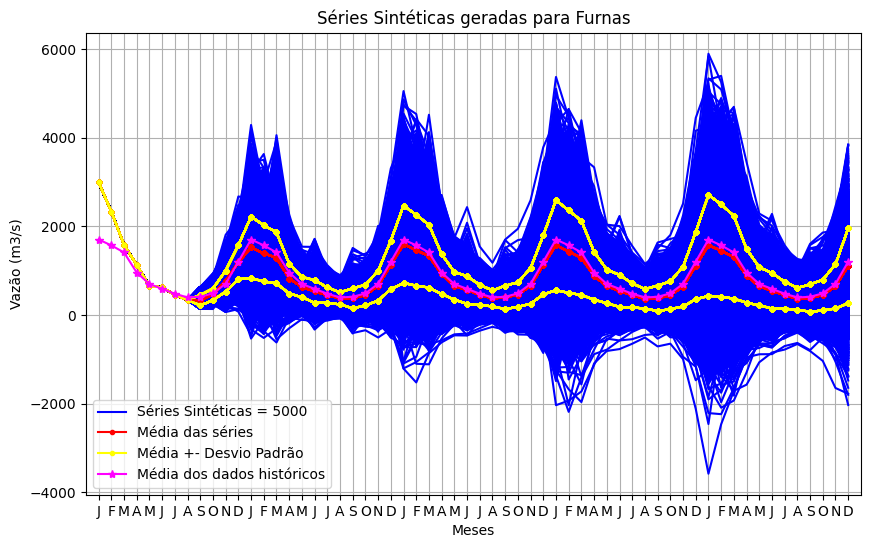

In [365]:
series = series_sinteticas(Nome_usina='Furnas',Melhor_ordem=Melhor_ordem,Ano_inicial_horizonte=2023,Mes_inicial='Setembro',Mes_final='Dezembro',Horizonte=5,Nr_series=5000,Ano_Atual=2023,grafico=True)